In [4]:
import pymongo as pmg
import pandas as pd
import datetime as dt
import pymysql
import matplotlib.pyplot as plt
from matplotlib.lines import TICKLEFT, TICKRIGHT, Line2D
from matplotlib.patches import Rectangle
import matplotlib as mpl
import matplotlib.dates as mdate
from datetime import time
from KRData.HKData import HKFuture
import talib as tb
import configparser
from kline import Kline
from bt_base import GetROI

In [3]:
conf_parser = configparser.ConfigParser()
conf_parser.read( 'conf.ini')
mg_host = conf_parser.get('MGDB', 'host')
mg_user = conf_parser.get('MGDB', 'user')
mg_password = conf_parser.get('MGDB', 'password')
hf=HKFuture(pwd=mg_password,host=mg_host,user=mg_user)

In [45]:
from bt_base import backtesting as bt


class bt_std(bt):
    #测试参数-----------------------------------------------------------------------
    def trade_para(self):
        self.Stop_Diff=60
        self.Stop_Macd_CNT=40
        
    def trade_main(self):
        cont=self.Macd_State in ['red','green']
        
        if cont and self._para['trade_p']['trade_state'] =='ready':
            self.trade_pre()
        if cont and self._para['trade_p']['trade_state']=='next':
            self.trade_open()
        if self._para['trade_p']['trade_state']=='open':
            self.trade_stop()
            if self._para['trade_p']['trade_state']=='open':
                return
            if cont and self._para['trade_p']['trade_state'] =='ready':
                self.trade_pre()
            if cont and self._para['trade_p']['trade_state']=='next':
                self.trade_open()
            
    def trade_init(self):
        self._para['trade']={}
        self._para['trade_p']={}
        self._para['trade_p']['trade_state']='ready'
        
    def trade_pre(self):
        trade=self._para['trade']
        trade_p=self._para['trade_p']
        macd=self.Macd_End
        cont=macd['ma60_state']=='over'
        cont1=self.Macd_State=='green' and macd['std_up']-macd['std_dn']<-1
        cont2=self.Macd_State=='red' and macd['std_up']-macd['std_dn']>1
        if cont and (cont1 or cont2):
            trade_p['trade_state']='next'
            trade['macd_no']=macd['day_no']
            trade['macd_state']=self.Macd_State
        
        self._para['trade']=trade
        self._para['trade_p']=trade_p
        
    def trade_open(self):
        trade=self._para['trade']
        trade_p=self._para['trade_p']
        macd=self._para['macd']
        row=self._para['row']
        cont=macd['day_no']==trade['macd_no']+1
        if cont:
            trade['open']=row['close']
            trade['date']=self._para['date']
            trade['open_idx']=self._para['day_no']
            trade['ma60_no']=macd['ma60_no']
            trade['macd_day_no']=macd['day_no']
            trade['state']='buy' if trade['macd_state']=='red' else 'sell'
            trade['stop_price']=row['open']-self.Stop_Diff if trade['state']=='buy' \
                                else row['open']+self.Stop_Diff
            trade_p['trade_state']='open'

        self._para['trade']=trade
        self._para['trade_p']=trade_p
    
    def trade_stop(self):
        trade=self._para['trade']
        trade_p=self._para['trade_p']
        ma60=self._para['ma60']
        macd=self._para['macd']
        row=self._para['row']
            
        cont1=row['close']<trade['stop_price'] and trade['state']=='buy'
        cont2=row['close']>trade['stop_price'] and trade['state']=='sell'
        cont3=macd['day_no']==trade['macd_day_no']+1
        cont4=macd['cnt']>self.Stop_Macd_CNT
        if any([cont1,cont2,cont3]):
            trade['close']=row['close']
            trade['close_type']='std'if cont3 else 'stop'
            trade['close_idx']=self._para['day_no']
            trade['diff']=trade['close']-trade['open'] if trade['state']=='buy' \
                        else trade['open'] -trade['close']
            trade['prod']=self._para['prod']
            self._res['trade'].append(trade)
            trade_p['trade_state']='ready'
            self._para['trade']={}
            
    #每日交易结束----------------------------------------------------------------------------------
    def trade_end(self):
        if self._para['trade_p']['trade_state'] in ['ready','open']:
            return
        trade=self._para['trade']
        row=self._para['row']
        if self._para['trade_p']['trade_state']=='open':
            trade['close']=row['open']
            trade['close_type']='end'
            trade['close_idx']=self._para['day_no']
            
        trade['diff']=trade['close']-trade['open'] if trade['state']=='buy' \
                                            else trade['open']-trade['close']
        trade['prod']=self._para['prod']
        self._res['trade'].append(trade)
        
print("--OK--")

--OK--


In [46]:
#测试计算
time1=dt.datetime.now()
print(time1)
test=bt_std(hf)
test.Stop_Diff=200
test.Stop_Macd_CNT=60
test.prod_all()
# test.prod_test('HSI1109')
time2=dt.datetime.now()
print(time2-time1)
trade=pd.DataFrame(test._res['trade'])
GetROI(trade)

2019-06-11 21:54:53.253007
0:02:38.331056


{'ALL_Profit': 10921.0,
 'All_CNT': 3773.0,
 'All_Mean': 2.8945136496156905,
 'Lose_CNT': 1015.0,
 'Lose_Max': -1.0,
 'Lose_Mean': -32.981280788177337,
 'Lose_Min': -264.0,
 'Lose_Sum': -33476.0,
 'ROI': 32.623371967977079,
 'Win%': 71.98515769944342,
 'Win/Lose': 0.4956285808081618,
 'Win_CNT': 2716.0,
 'Win_Max': 310.0,
 'Win_Mean': 16.346465390279825,
 'Win_Min': 1.0,
 'Win_Sum': 44397.0}

In [54]:
trade.head()
trade.sort_values('diff',ascending=True)

,close,close_idx,close_type,date,diff,ma60_no,macd_day_no,macd_no,macd_state,open,open_idx,prod,state,stop_price
1715,23845.0,77,stop,2014-12-05,-264.0,0,3,2,red,24109.0,59,HSI1412,buy,23933.0
1882,27150.0,112,stop,2015-04-09,-260.0,2,11,10,green,26890.0,99,HSI1504,sell,27116.0
32,23278.0,54,stop,2011-02-09,-233.0,2,1,0,red,23511.0,25,HSI1102,buy,23311.0
2222,19163.0,84,stop,2016-01-19,-233.0,0,3,2,red,19396.0,57,HSI1601,buy,19197.0
363,17847.0,125,stop,2011-11-30,-231.0,4,6,5,red,18078.0,80,HSI1112,buy,17895.0
1906,27996.0,52,stop,2015-05-04,-226.0,0,1,0,red,28222.0,22,HSI1505,buy,28053.0
3376,28617.0,353,stop,2018-07-10,-224.0,8,21,20,red,28841.0,295,HSI1807,buy,28657.0
3165,32582.0,117,stop,2018-01-31,-217.0,3,5,4,green,32365.0,92,HSI1802,sell,32551.0
3311,30828.0,256,stop,2018-05-16,-213.0,8,13,12,red,31041.0,216,HSI1805,buy,30837.0
3153,32801.0,118,stop,2018-01-23,-212.0,2,4,3,green,32589.0,88,HSI1801,sell,32786.0


In [44]:
#循环测试某个参数
Calc=['sum','count','mean','std','max','min']
time1=dt.datetime.now()
print(time1)
TestAll={}
df={}
for i in range(20,200,10):
    print(i)
    test=bt_std(hf,index='HSI')
    test.Stop_Macd_CNT=i
    test.prod_all()
#     test.prod_test('HSI1903')
    df[i]=pd.DataFrame(test._res['trade'])
    TestAll[i]=GetROI(df[i])
time2=dt.datetime.now()
print(time2-time1)
pd.DataFrame(TestAll).T

2019-06-11 18:45:13.881254
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
0:47:30.956065


,ALL_Profit,All_CNT,All_Mean,Lose_CNT,Lose_Max,Lose_Mean,Lose_Min,Lose_Sum,ROI,Win%,Win/Lose,Win_CNT,Win_Max,Win_Mean,Win_Min,Win_Sum
20,6496.0,3820.0,1.700524,1123.0,-1.0,-33.280499,-339.0,-37374.0,17.381067,69.581152,0.495933,2658.0,310.0,16.504891,1.0,43870.0
30,7251.0,3801.0,1.907656,1048.0,-1.0,-35.435115,-391.0,-37136.0,19.525528,71.375954,0.461713,2713.0,310.0,16.360855,1.0,44387.0
40,9402.0,3785.0,2.484016,1028.0,-1.0,-34.038911,-427.0,-34992.0,26.868999,71.730515,0.480373,2715.0,310.0,16.351381,1.0,44394.0
50,10481.0,3775.0,2.776424,1017.0,-1.0,-33.349066,-449.0,-33916.0,30.902819,71.947020,0.490163,2716.0,310.0,16.346465,1.0,44397.0
60,10932.0,3772.0,2.898197,1014.0,-1.0,-33.002959,-409.0,-33465.0,32.666965,72.004242,0.495303,2716.0,310.0,16.346465,1.0,44397.0
70,10711.0,3772.0,2.839608,1014.0,-1.0,-33.220907,-409.0,-33686.0,31.796592,72.004242,0.492054,2716.0,310.0,16.346465,1.0,44397.0
80,10665.0,3772.0,2.827413,1014.0,-1.0,-33.266272,-437.0,-33732.0,31.616862,72.004242,0.491383,2716.0,310.0,16.346465,1.0,44397.0
90,11087.0,3771.0,2.940069,1013.0,-1.0,-32.882527,-432.0,-33310.0,33.284299,72.023336,0.497117,2716.0,310.0,16.346465,1.0,44397.0
100,11086.0,3771.0,2.939804,1013.0,-1.0,-32.883514,-441.0,-33311.0,33.280298,72.023336,0.497102,2716.0,310.0,16.346465,1.0,44397.0
110,11102.0,3771.0,2.944047,1013.0,-1.0,-32.867720,-425.0,-33295.0,33.344346,72.023336,0.497341,2716.0,310.0,16.346465,1.0,44397.0


In [41]:
test.Macd_State
test._para['trade_p']
test.Macd_State 
test.Macd_State in ['red','green']
test._para['trade_p']['trade_state']=='open'

False

In [3]:
from bt_base import GetROI
GetROI(trade)

NameError: name 'trade' is not defined

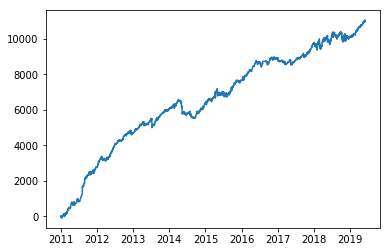

In [29]:
trade.head()
plt.plot(trade.date,trade['diff'].cumsum())

In [5]:
macd=pd.read_pickle("pkl/macd.pkl")
cols=['date','no','cnt','diff','std_up','std_dn']
cols1=['date1','no1','cnt1','diff1','std_up1','std_dn1']
cols2=['date2','no2','cnt2','diff2','std_up2','std_dn2']
macd1=macd[cols].copy()
macd1.columns=cols1
macd2=macd[cols].copy()
macd2.columns=cols2
m2=macd.join(macd1.shift(-1))
m2=m2.join(macd2.shift(-2))
m3=m2[(m2.date==m2.date1) & (m2.date==m2.date2)]
m3.head()

,begin,begin_idx,cnt,date,day_no,diff,end,end_idx,ma60_no,ma60_state,...,cnt1,diff1,std_up1,std_dn1,date2,no2,cnt2,diff2,std_up2,std_dn2
1,23123.0,29,18,2011-01-03,1,-4.0,23119.0,47,0,under,...,5.0,-12.0,0.0,0.0,2011-01-03,2.0,43.0,251.0,3.0,0.0
2,23119.0,47,5,2011-01-03,2,-12.0,23131.0,52,0,under,...,43.0,251.0,3.0,0.0,2011-01-03,1.0,4.0,-34.0,0.0,0.0
3,23131.0,52,43,2011-01-03,3,251.0,23382.0,95,0,under,...,4.0,-34.0,0.0,0.0,2011-01-03,1.0,12.0,-28.0,0.0,0.0
4,23382.0,95,4,2011-01-03,4,-34.0,23416.0,99,1,over,...,12.0,-28.0,0.0,0.0,2011-01-03,2.0,9.0,-14.0,0.0,0.0
5,23416.0,99,12,2011-01-03,5,-28.0,23388.0,111,1,over,...,9.0,-14.0,0.0,0.0,2011-01-03,2.0,17.0,0.0,0.0,0.0


In [20]:
Calc=['sum','count','mean','std','max','min']
m3.groupby(['ma60_state','state',m3.std_up-m3.std_dn])['diff1','diff2'].agg(Calc).to_excel('std_shift.xls')

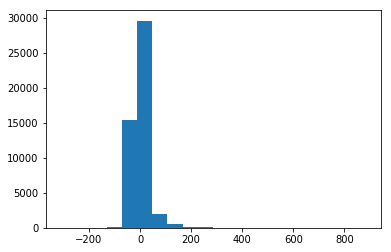

In [8]:
plt.hist(m3.diff1,bins=20)
plt.show()

In [65]:
Calc=['sum','count','mean','std','max','min']
m3.groupby(['ma60_state','state',m3.std_up-m3.std_dn])['diff1'].agg(Calc).to_excel('std_shift1.xls')
# m3.groupby(['ma60_state','state',m3['diff']//50])['diff1'].agg(Calc)

In [18]:
cont2=(m3.ma60_state=='over') & (m3.state=='green') & (m3.std_up-m3.std_dn<-1)
cont3=(m3.ma60_state=='over') & (m3.state=='red') & (m3.std_up-m3.std_dn>1)
m4=m3[cont2][['diff1','date']]
m4.columns=['diff','date']
m5=m3[cont3 | cont2][['diff1','date']]
m5.columns=['diff','date']
GetROI(m5)

NameError: name 'GetROI' is not defined

In [19]:
from bt_base import GetROI
GetROI(m5)

{'ALL_Profit': -11270.0,
 'All_CNT': 3312.0,
 'All_Mean': -3.4027777777777777,
 'Lose_CNT': 2414.0,
 'Lose_Max': -1.0,
 'Lose_Mean': -15.768019884009941,
 'Lose_Min': -310.0,
 'Lose_Sum': -38064.0,
 'ROI': -29.608028583438411,
 'Win%': 25.966183574879228,
 'Win/Lose': 1.9758862674369728,
 'Win_CNT': 860.0,
 'Win_Max': 425.0,
 'Win_Mean': 31.155813953488373,
 'Win_Min': 1.0,
 'Win_Sum': 26794.0}

In [34]:
GetROI(m5[m5['diff'].between(-150,50)])

{'ALL_Profit': -23245.0,
 'All_CNT': 3119.0,
 'All_Mean': -7.4527092016672007,
 'Lose_CNT': 2374.0,
 'Lose_Max': -1.0,
 'Lose_Mean': -14.79486099410278,
 'Lose_Min': -50.0,
 'Lose_Sum': -35123.0,
 'ROI': -66.181704296330039,
 'Win%': 22.66752164155178,
 'Win/Lose': 1.1355676662024397,
 'Win_CNT': 707.0,
 'Win_Max': 50.0,
 'Win_Mean': 16.8005657708628,
 'Win_Min': 1.0,
 'Win_Sum': 11878.0}

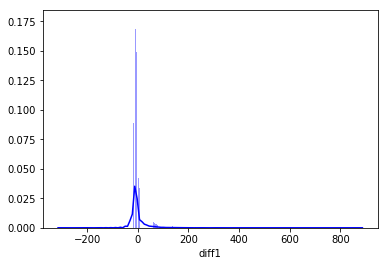

In [13]:
import seaborn as sns

sns.distplot(m3.diff1, hist=True, kde=True,bins=5000,color='b')
# sns.distplot(m3.diff2, hist=True, kde=True)
plt.show()

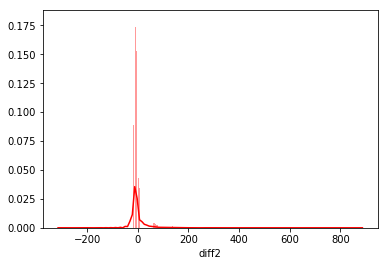

In [12]:
sns.distplot(m3.diff2, hist=True, kde=True,bins=5000,color='r')
plt.show()

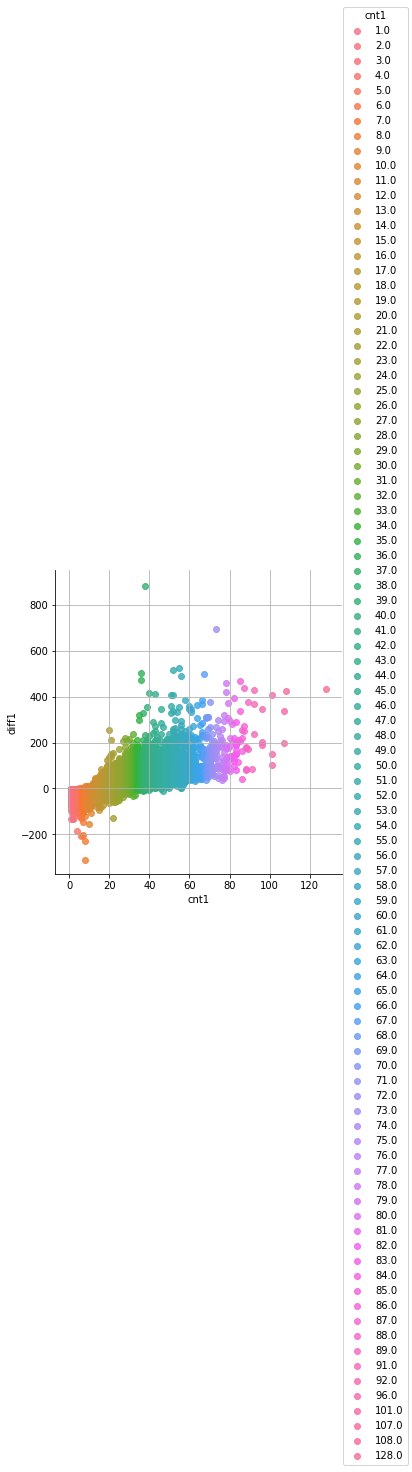

In [29]:
sns.lmplot('cnt1','diff1',m3, hue='cnt1',fit_reg=False)
plt.grid(True)
# m3.head()
plt.show()

In [51]:
def drawKK(k,prod,date,**para):
    t1=dt.time(9,15,0)
    t2=dt.time(16,30,0)
    # a2=aa[aa.datetime.apply(lambda x:t1<=x.time()<=t2)]
    rec_end=66
    test1=bt(hf)
    # prod='HSI1103'
    test1.prod_init(prod)
    aa=test1._para['df_prod']
    a2=aa[aa.datetime.apply(lambda x:t1<=x.time()<=t2)]
    # date='2011-02-28'
    k.DrawKline(a2[a2.trade_date==date],rec=(7,66),**para)

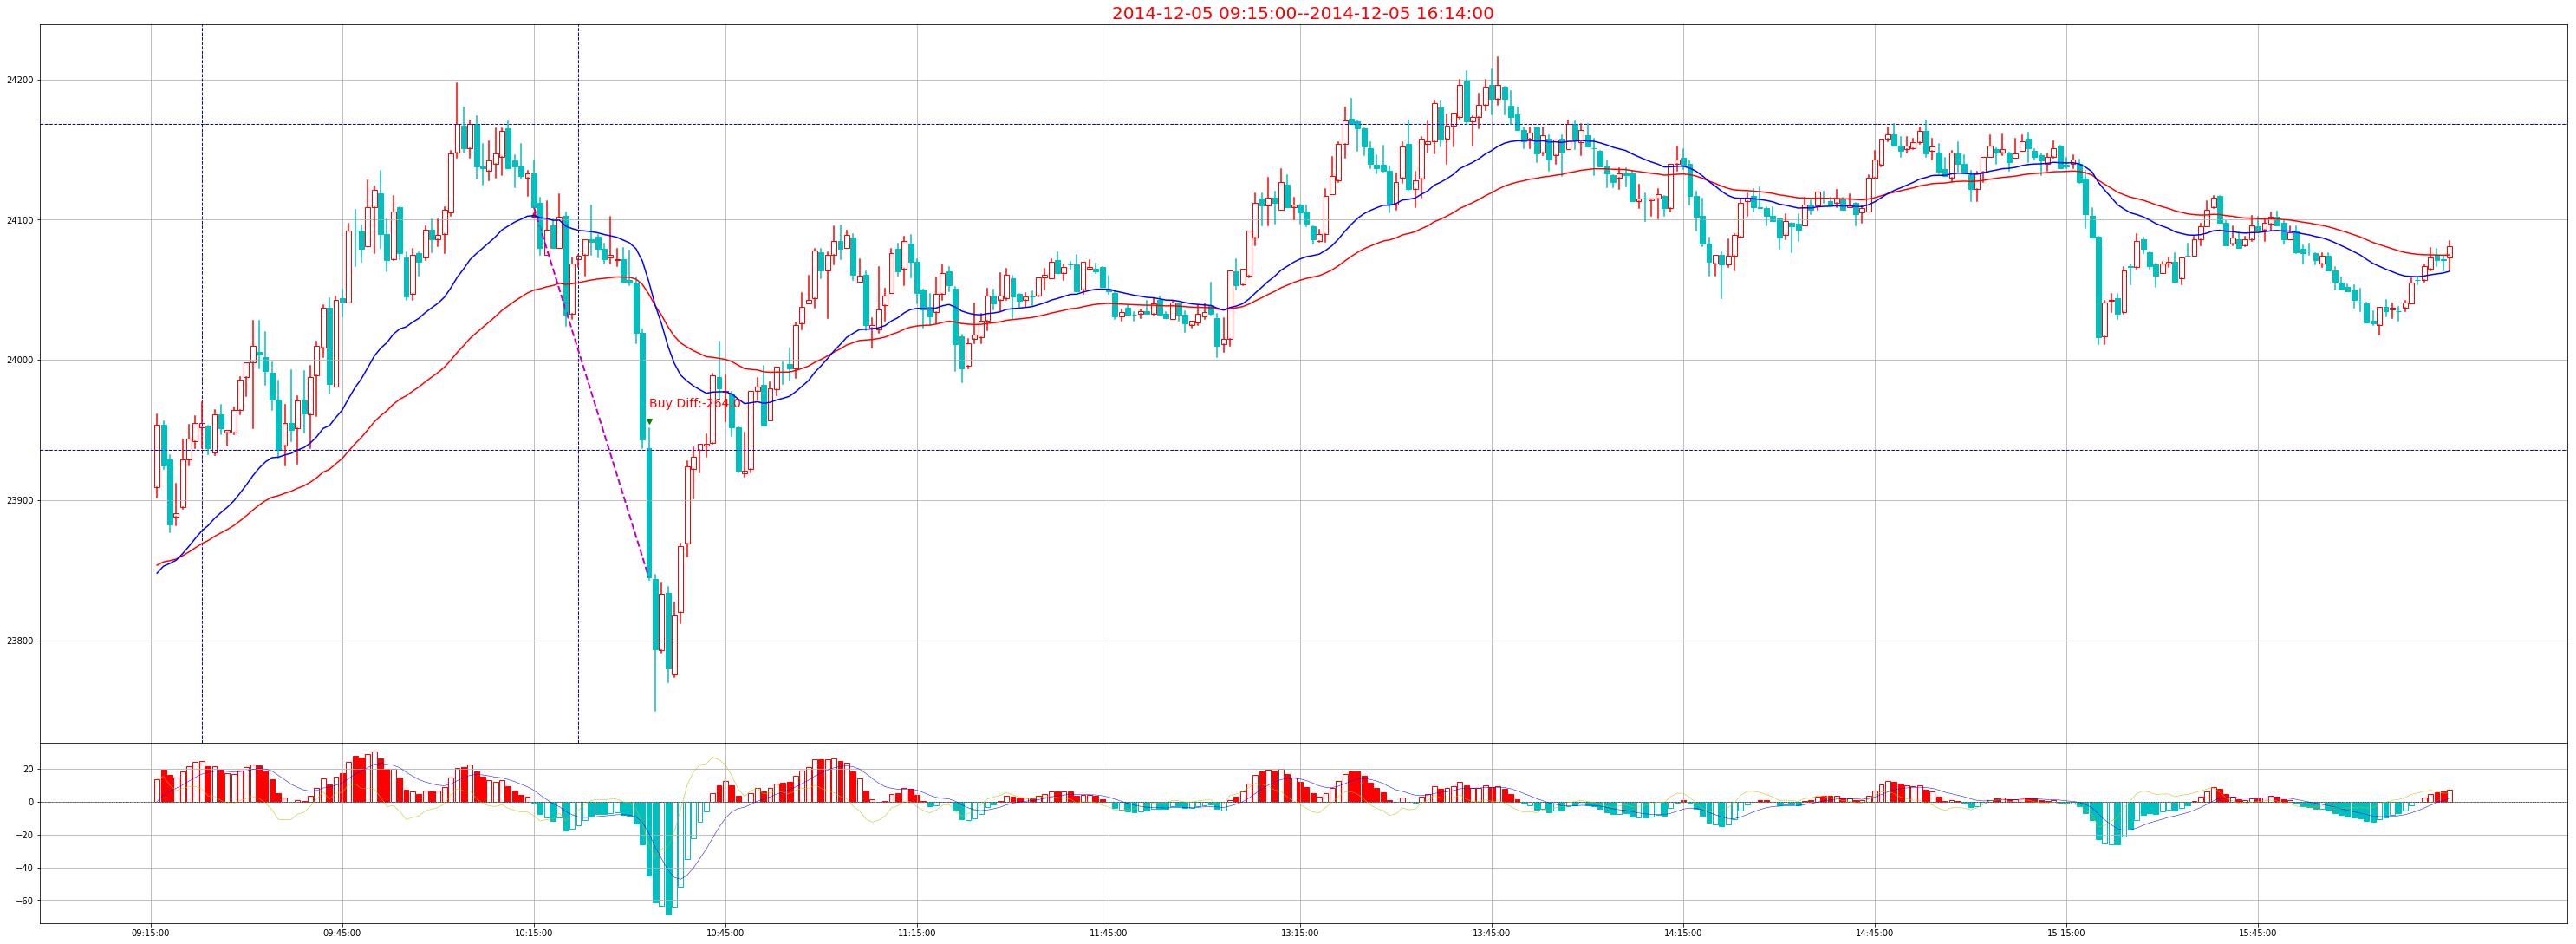

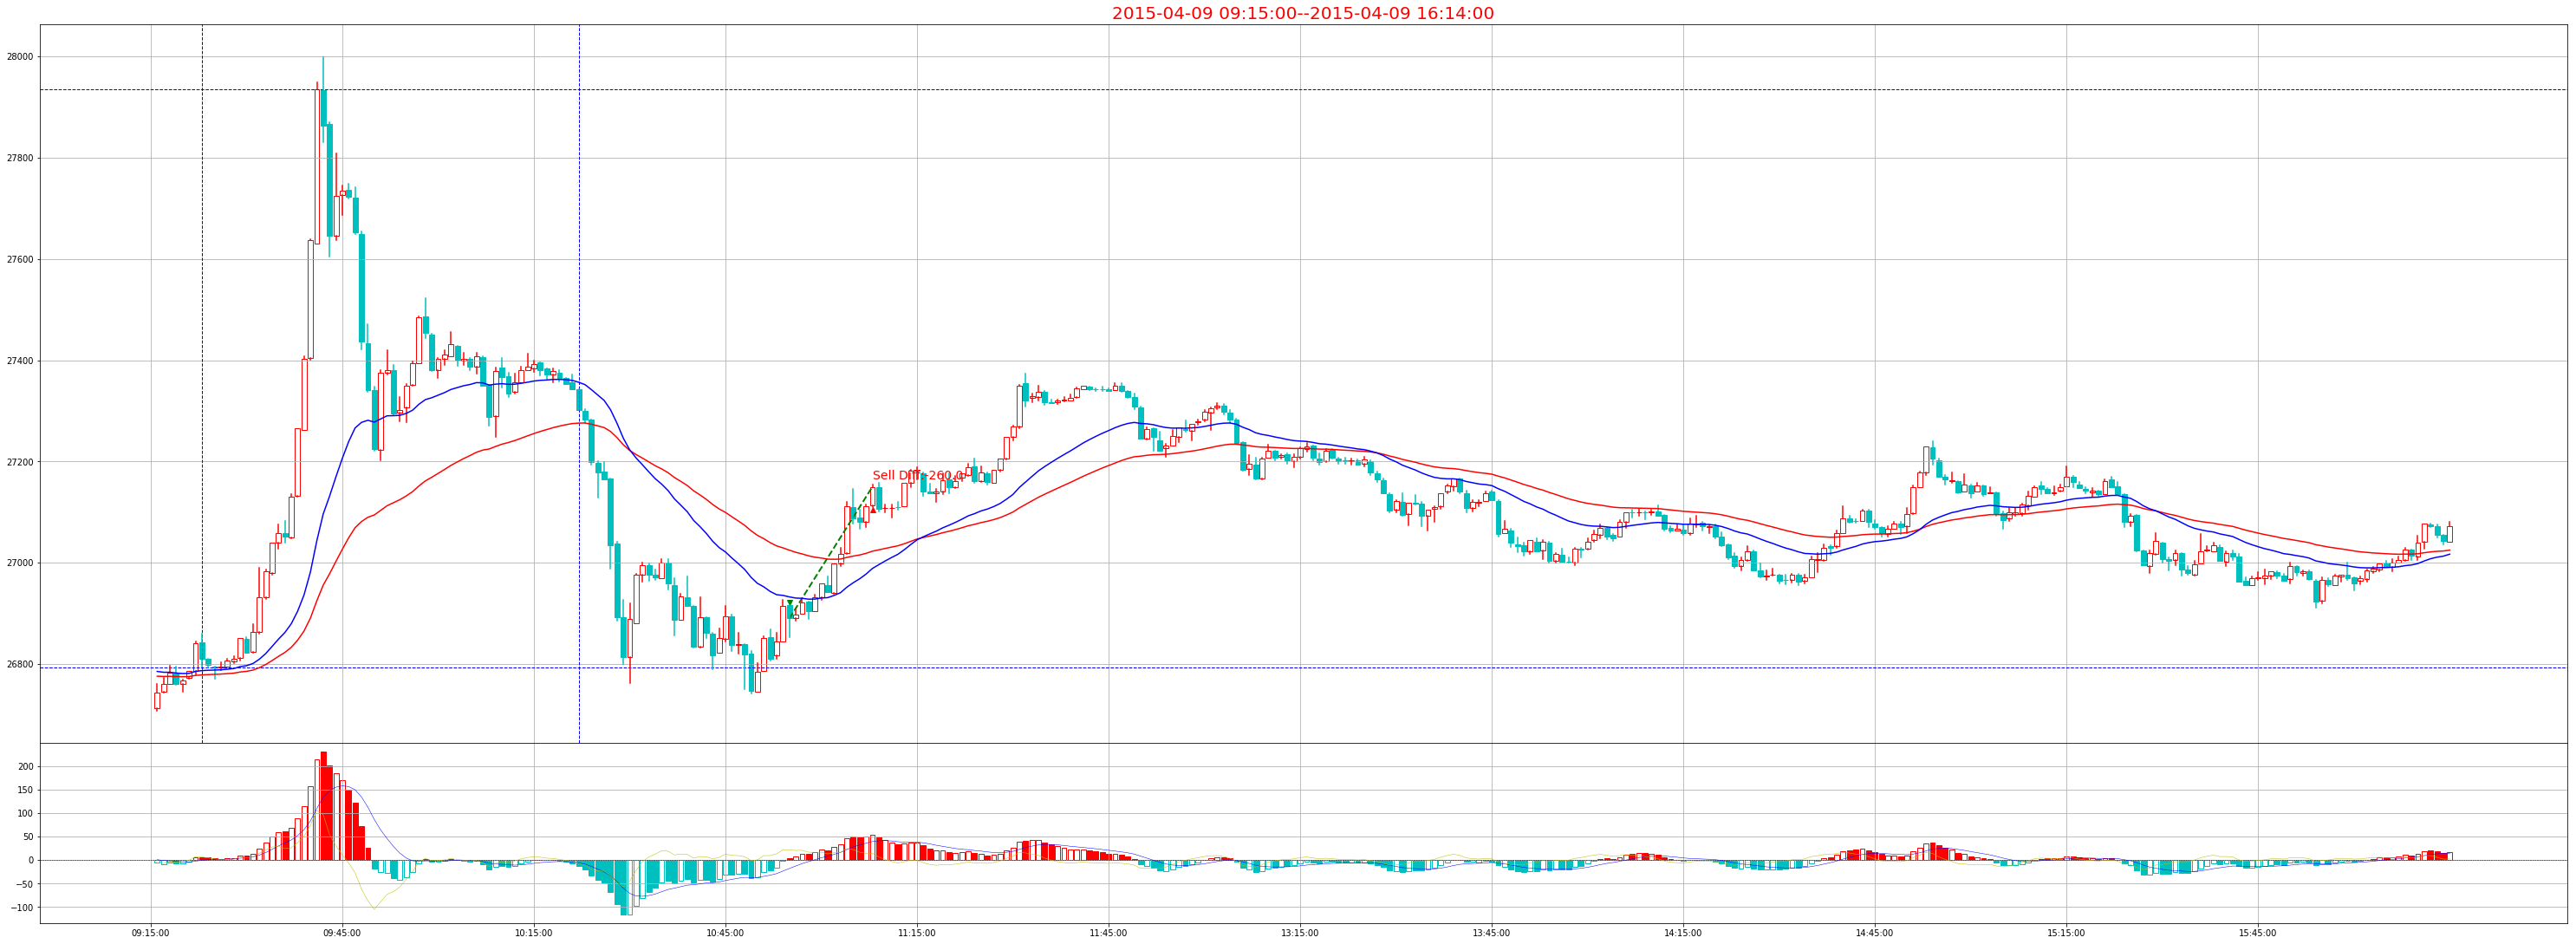

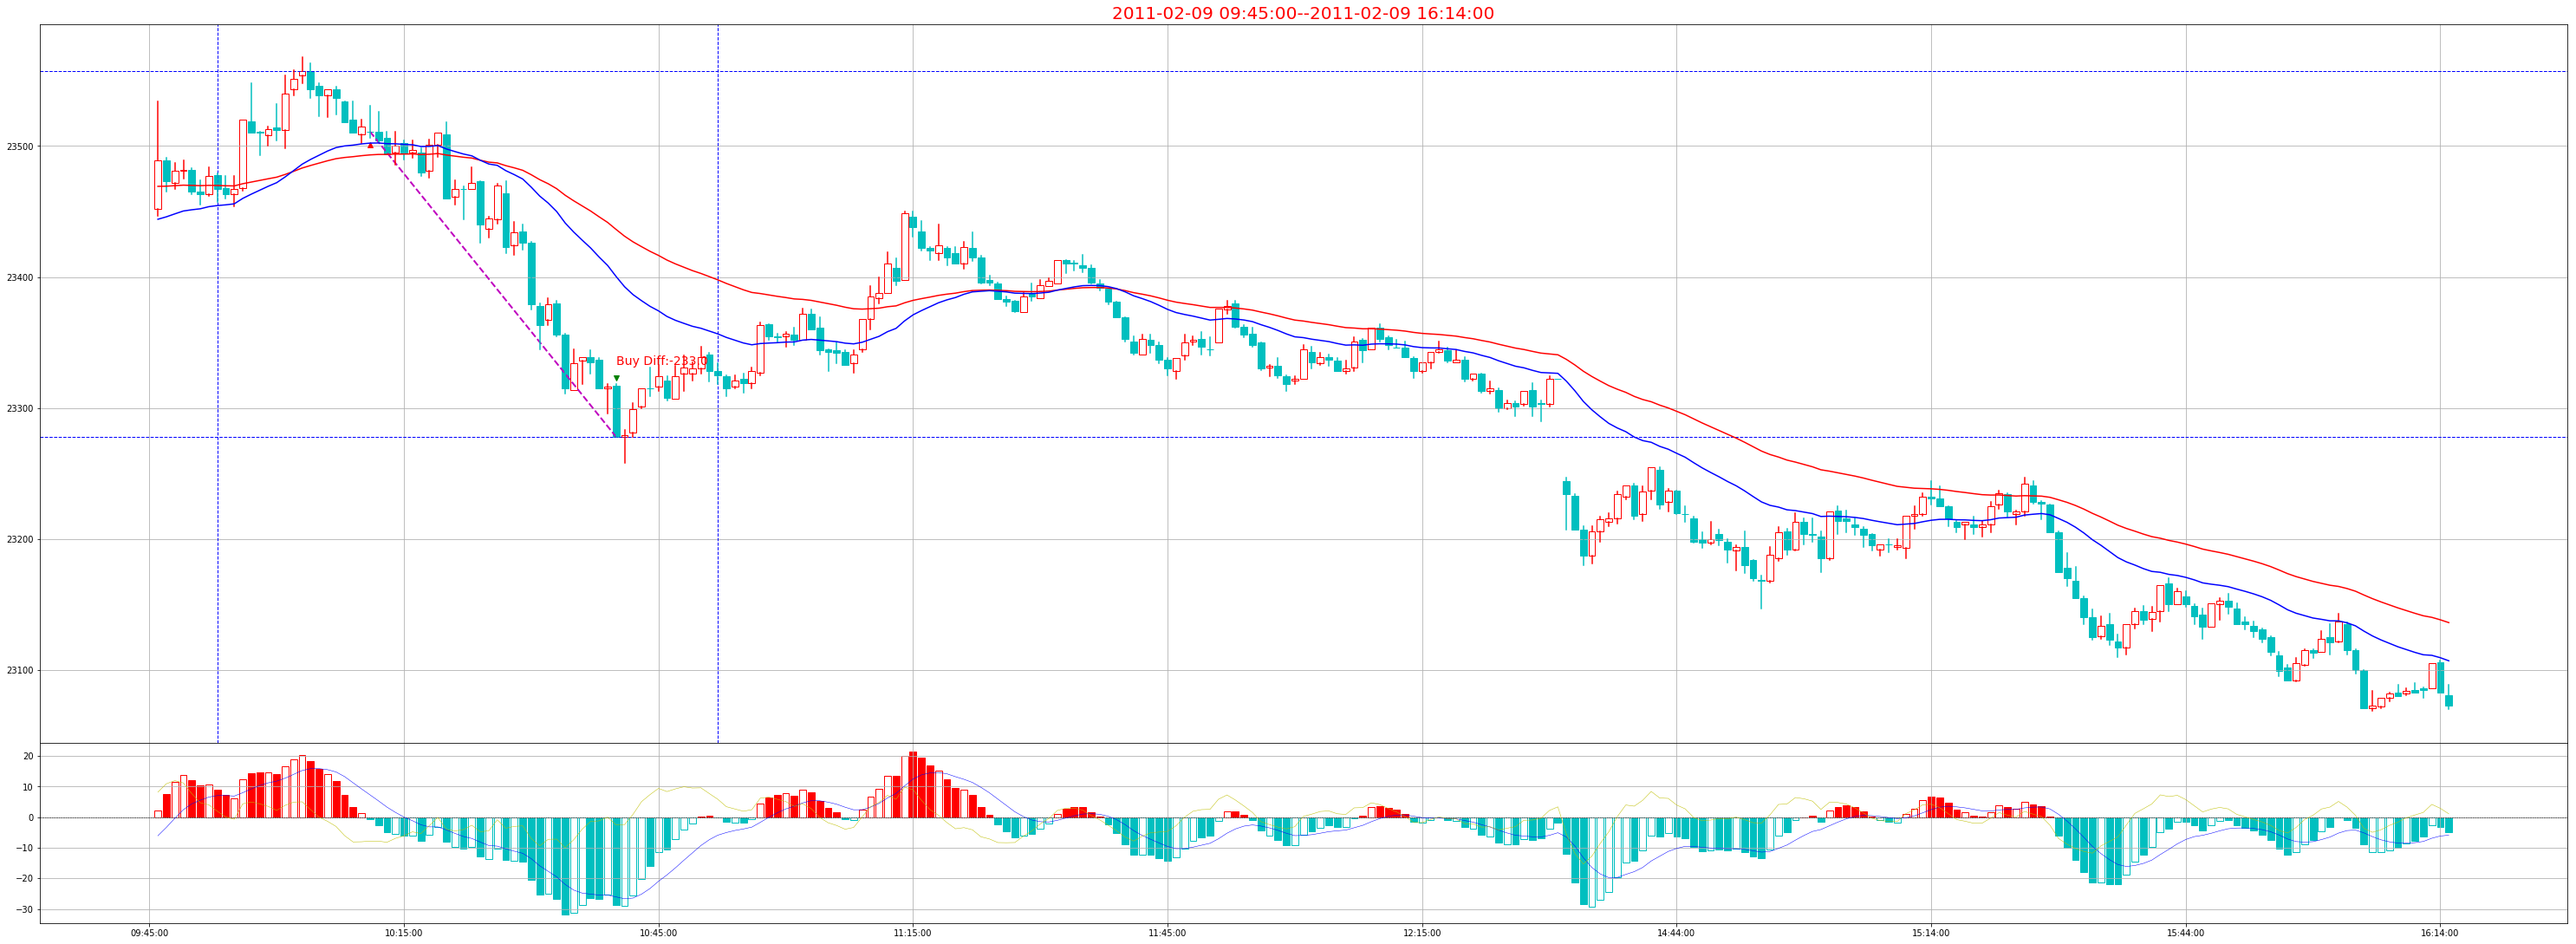

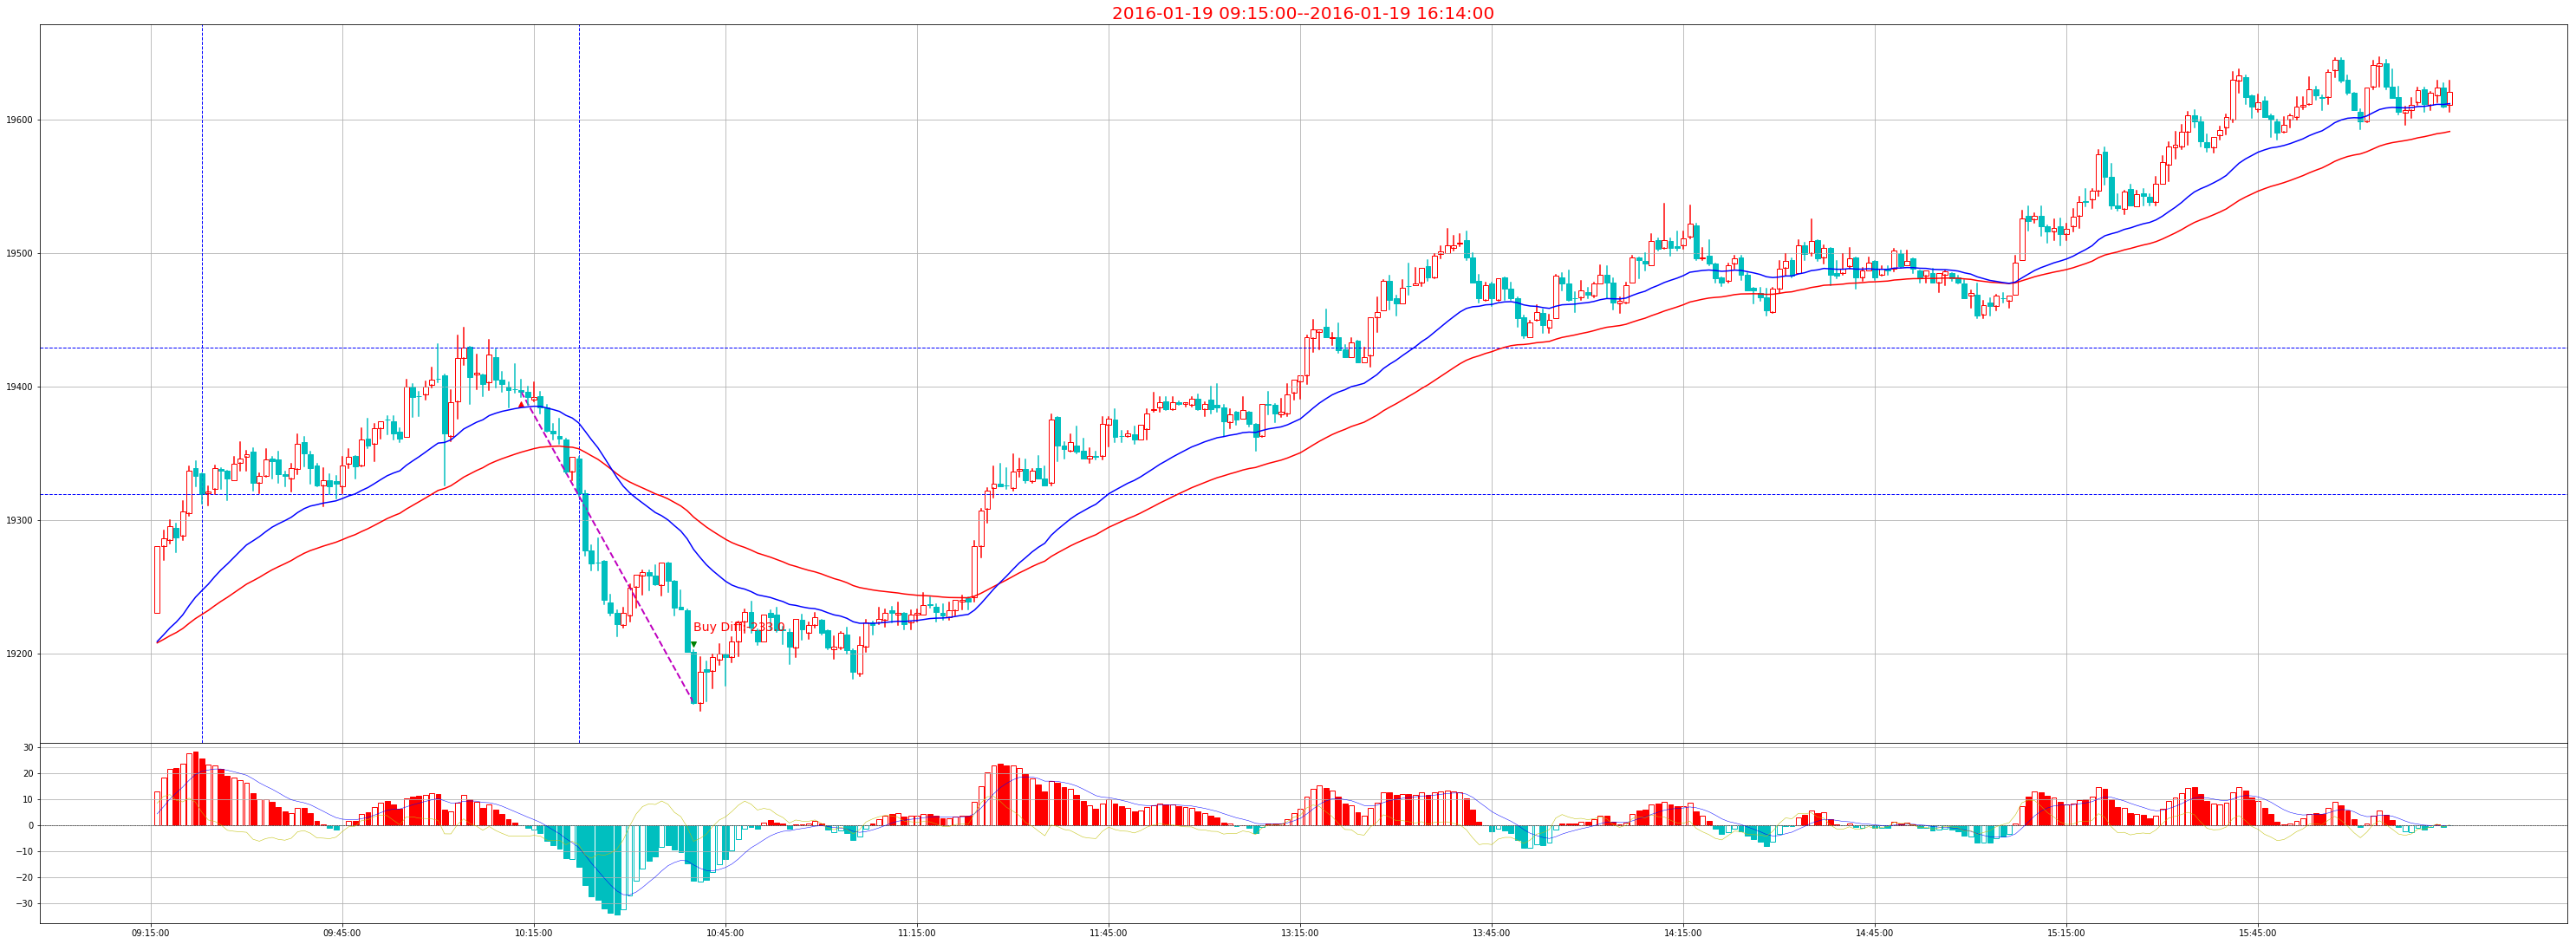

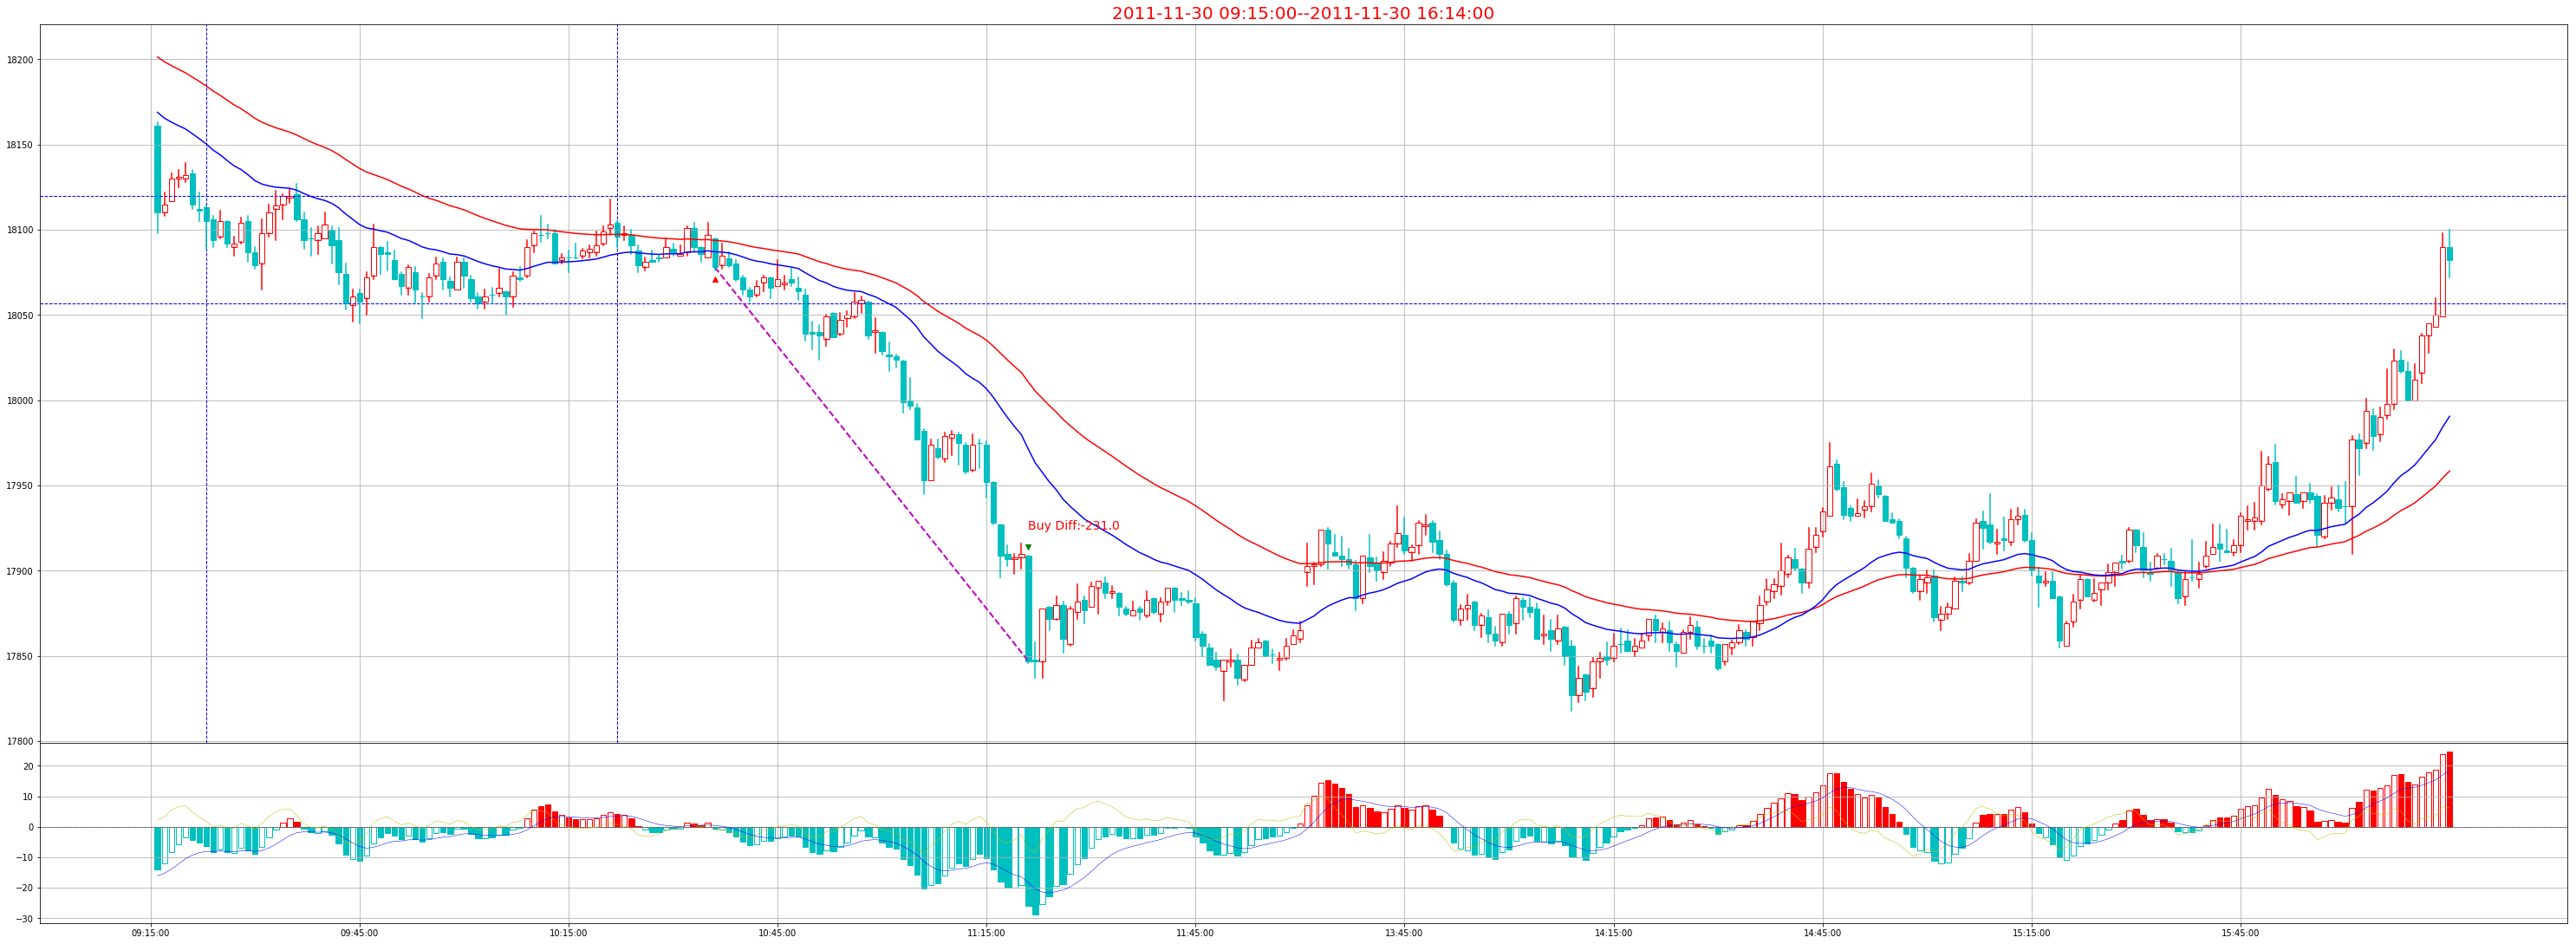

In [53]:
#图显
from kline import Kline
k=Kline()
# drawKK(k,'HSI1103','2011-02-28')
# cont=(macd.state=='red') &(macd.no==1) & (macd.ma60_state=='under')
df2=trade.sort_values('diff')
for i,row in df2.head(5).iterrows():
#     print(row['prod'],row['date'])
    file="img/macd_h10_%s"%(row['date'].date())
    idx1=int(row['open_idx'])
    idx2=int(row['close_idx'])
    drawKK(k,row['prod'],row['date'],trade=[row['state'],idx1,idx2])